In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
def quadratic_function(x, A):
    """
    Define la función cuadrática f(x) = 1/2 * x^T * A * x.
    """
    return 0.5 * x.T @ A @ x
def gradient_of_quadratic(x, A):
    """
    Calcula el gradiente de la función cuadrática, que es A * x.
    """
    return A @ x

In [25]:
def met_gradiente(A, x0, lr, f , gf, maxiter = 100000):
    trayectoria = [x0]
    valores = [f(x0,A)]
    x = x0.copy()
    for _ in range(maxiter):
        gradf = gf(x,A)
        paso_optim = gradf.T@gradf/(gradf.T@A@gradf)
        x -= lr*paso_optim*gradf
        trayectoria += [x.copy()]
        valores.append(f(x,A))
    return x, trayectoria

In [26]:
x0 = np.random.rand(300)*10

In [27]:
A = np.load("/content/drive/MyDrive/LCD/IO/matriz.npy")

In [28]:
x, trayectoria =met_gradiente(A, x0, lr=0.5 , f=quadratic_function, gf=gradient_of_quadratic)

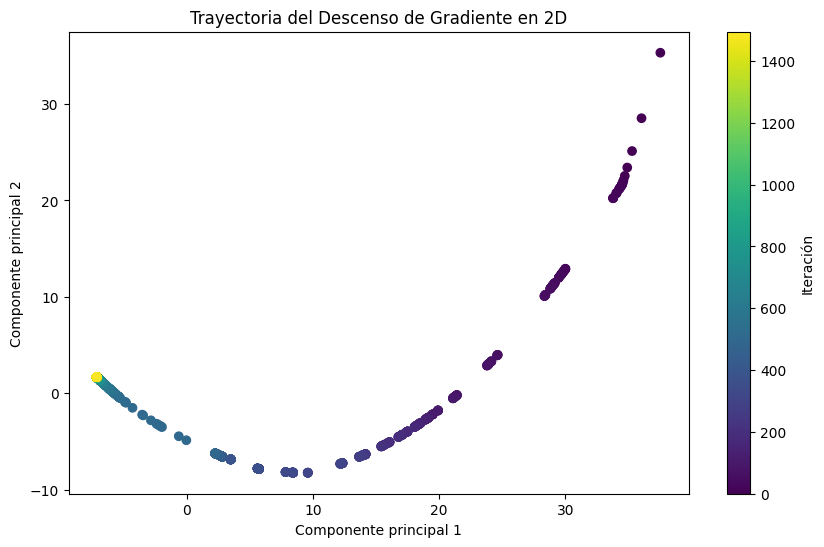

In [38]:

from sklearn.decomposition import PCA

tray = []
for i in range(500):
  tray.append(trayectoria[i])

for i in range(500, len(trayectoria)):
  if(i % 100 == 0):
    tray.append(trayectoria[i])


trayectoria_np = np.array(tray)

# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
trayectoria_2d = pca.fit_transform(trayectoria_np)

# Graficar la trayectoria en 2D
plt.figure(figsize=(10, 6))
plt.scatter(trayectoria_2d[:, 0], trayectoria_2d[:, 1], c=np.arange(len(trayectoria_2d)), cmap='viridis')
plt.title('Trayectoria del Descenso de Gradiente en 2D')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.colorbar(label='Iteración')
plt.show()